<a href="https://colab.research.google.com/github/ankitdv98/Chest-x-ray-prediction/blob/main/Chest_x_ray_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Push data from kaggle

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from google.colab import files
!pip install -q kaggle

In [2]:
!ls

drive  sample_data


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle/X-ray Model"# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
#changing the working directory
%cd /content/drive/MyDrive/Kaggle/X-ray Model


/content/drive/MyDrive/Kaggle/X-ray Model


In [5]:
#Check the present working directory using pwd command
!pwd

/content/drive/My Drive/Kaggle/X-ray Model


In [10]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:42<00:00, 50.4MB/s]
100% 2.29G/2.29G [00:42<00:00, 58.4MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

In [6]:
!nvidia-smi

Fri Jan 15 11:05:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |    359MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Vgg16 model
Using transfer learning approach

In [7]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [8]:
IMAGE_SIZE = [224, 224]

train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path= 'chest_xray/val'

In [26]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# using existing weights of vgg16
for layer in vgg.layers:
  layer.trainable = False

In [27]:
# no of classes
folders= glob(train_path+"/*")
print(len(folders))
folders

2


['chest_xray/train/NORMAL', 'chest_xray/train/PNEUMONIA']

In [28]:
x= Flatten()(vgg.output)
pred= Dense(len(folders), activation= 'softmax')(x)

model= Model(inputs= vgg.input, outputs= pred)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Generating image data

In [12]:
train_gen= ImageDataGenerator(rescale= 1./255,
                              shear_range= 0.2,
                              zoom_range= 0.2,
                              horizontal_flip= True,
                              rotation_range= 0.2
                              )
valid_gen= ImageDataGenerator(rescale= 1./255)
test_gen= ImageDataGenerator(rescale= 1./255)

In [13]:
train_ds= train_gen.flow_from_directory(train_path,
                                        target_size= (224,224),
                                        batch_size= 32,
                                        class_mode= 'categorical')
valid_ds= valid_gen.flow_from_directory('chest_xray/val',
                                        target_size= (224,224),
                                        batch_size= 32,
                                        class_mode= 'categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [14]:
test_ds= valid_gen.flow_from_directory(test_path,
                                        target_size= (224,224),
                                        batch_size= 32,
                                        class_mode= 'categorical')

Found 624 images belonging to 2 classes.


# model training and visualization
Training on train and validating model on test data

In [29]:
r = model.fit(train_ds,
              validation_data= test_ds,
              epochs= 5,
              steps_per_epoch=len(train_ds),
              validation_steps=len(test_ds)
              )
# trained only for 5 epochs but updated weights for every batch obtained from data generator

Epoch 1/5
163/163 [==============================] - 1333s 8s/step - loss: 0.3959 - accuracy: 0.8357 - val_loss: 0.2237 - val_accuracy: 0.9167
Epoch 2/5
163/163 [==============================] - 106s 651ms/step - loss: 0.1062 - accuracy: 0.9565 - val_loss: 0.5299 - val_accuracy: 0.8269
Epoch 3/5
163/163 [==============================] - 106s 648ms/step - loss: 0.0977 - accuracy: 0.9614 - val_loss: 0.2234 - val_accuracy: 0.9151
Epoch 4/5
163/163 [==============================] - 105s 645ms/step - loss: 0.0803 - accuracy: 0.9708 - val_loss: 0.2739 - val_accuracy: 0.9038
Epoch 5/5
163/163 [==============================] - 105s 643ms/step - loss: 0.0827 - accuracy: 0.9712 - val_loss: 0.4527 - val_accuracy: 0.8942


In [30]:
r.history

{'accuracy': [0.9097009301185608,
  0.9570552110671997,
  0.9660659432411194,
  0.9679831266403198,
  0.9706671833992004],
 'loss': [0.22271126508712769,
  0.106997050344944,
  0.08835399150848389,
  0.09016189724206924,
  0.08060978353023529],
 'val_accuracy': [0.9166666865348816,
  0.8269230723381042,
  0.9150640964508057,
  0.9038461446762085,
  0.8942307829856873],
 'val_loss': [0.22367596626281738,
  0.5298841595649719,
  0.22341953217983246,
  0.27391138672828674,
  0.45267945528030396]}

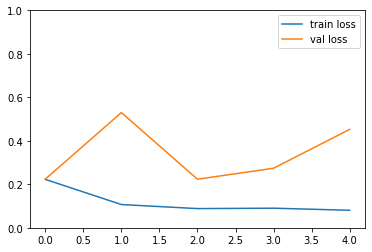

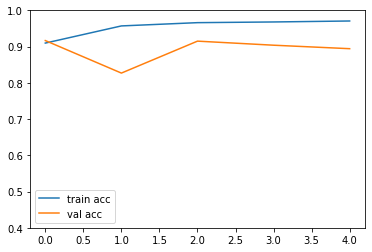

<Figure size 432x288 with 0 Axes>

In [35]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.ylim(0, 1)
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.ylim(0.4, 1)
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [36]:
model.save('x-ray_model_vgg19.h5')

# Prediction of new images
Valid data contains 8 images for each class

In [49]:
from tensorflow.keras.models import load_model
model = load_model('x-ray_model_vgg19.h5')

In [54]:
# data generator gives image array
img_to_pred= in_img.reshape(1, in_img.shape[0], in_img.shape[1], in_img.shape[2])

1 , Actual Class: Pneumonia
Predicted Class: Pneumonia 
2 , Actual Class: Normal
Predicted Class: Pneumonia 


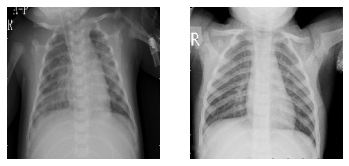

In [90]:
x,y = valid_ds.next()

for i in range(2):
    image = x[i]
    in_img= image
    img_to_pred= in_img.reshape(1, in_img.shape[0], in_img.shape[1], in_img.shape[2])
    pred= np.argmax(model.predict(img_to_pred))
    if np.argmax(y[i])== 0:
      print(i+1, ", Actual Class: Normal")
    else:
      print(i+1, ", Actual Class: Pneumonia")
    if pred==0:
      print("Predicted Class: Normal")
    else:
      print("Predicted Class: Pneumonia ")
    plt.subplot(1,2, i+1)
    plt.imshow(image)
    plt.axis("off")

